<a href="https://colab.research.google.com/github/zhukuixi/Fastai/blob/main/fastai_lesson4_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Kaggle Competition Data

In [1]:
import json
token = {"username":"kuixizhu","key":"dc7d6e998e4b5eb9417913d844e0df0b"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)
  


In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Assign path
!kaggle config set -n path -v /content
# Download data
!kaggle competitions download -c us-patent-phrase-to-phrase-matching

- path is now set to: /content
  0% 0.00/682k [00:00<?, ?B/s]
100% 682k/682k [00:00<00:00, 89.1MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
#!mv "/content/competitions/" "/content/gdrive/MyDrive"
!unzip /content/gdrive/MyDrive/competitions/us-patent-phrase-to-phrase-matching/us-patent-phrase-to-phrase-matching.zip -d /content/gdrive/MyDrive/competitions/us-patent-phrase-to-phrase-matching/

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/competitions/us-patent-phrase-to-phrase-matching/us-patent-phrase-to-phrase-matching.zip
replace /content/gdrive/MyDrive/competitions/us-patent-phrase-to-phrase-matching/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## EDA

In [4]:
import pandas as pd
from pathlib import Path
path = Path('/content/gdrive/MyDrive/competitions/us-patent-phrase-to-phrase-matching')
!ls {path}

sample_submission.csv  train.csv
test.csv	       us-patent-phrase-to-phrase-matching.zip


In [5]:
df = pd.read_csv(path/"train.csv")
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [6]:
df.describe(include='object')


,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [7]:
# Feature Engineering 
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.input.head()


0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

## Tokenization


## transformer只能用Dataset这种类别的data，因此要先完成数据转换

In [8]:
!pip install -q datasets
from datasets import Dataset,DatasetDict
ds = Dataset.from_pandas(df)


     |████████████████████████████████| 365 kB 4.1 MB/s 
     |████████████████████████████████| 120 kB 74.5 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 115 kB 65.4 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 


In [9]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [10]:
model_nm = 'microsoft/deberta-v3-small'
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
     |████████████████████████████████| 6.6 MB 46.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.1 MB/s 


In [11]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
# Tokenize in a way fits the assigned model
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
def tok_func(x): return tokz(x["input"])

In [13]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [14]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [15]:
tokz.vocab['▁of']

265

In [16]:
tok_ds = tok_ds.rename_columns({'score':'labels'})


## Test and validation sets


In [17]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [18]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [19]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
def corr(x,y): return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}



## Training


In [21]:
from transformers import TrainingArguments,Trainer
import numpy as np

In [22]:
bs = 128
epochs = 4
lr = 8e-5

设置模型参数

In [23]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

设置模型和Trainer

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [25]:
trainer.train();


The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, context, target, input, id. If anchor, context, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024867,0.801632
2,No log,0.023620,0.823012
3,0.035700,0.023971,0.828808
4,0.035700,0.023045,0.830899


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, context, target, input, id. If anchor, context, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, context, target, input, id. If anchor, context, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved 

In [26]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, context, target, input, id. If anchor, context, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 256


array([[ 0.52392578],
       [ 0.67529297],
       [ 0.56933594],
       [ 0.35009766],
       [-0.03601074],
       [ 0.57226562],
       [ 0.53076172],
       [ 0.05670166],
       [ 0.24377441],
       [ 1.10644531],
       [ 0.2331543 ],
       [ 0.24023438],
       [ 0.73925781],
       [ 0.88916016],
       [ 0.74951172],
       [ 0.46679688],
       [ 0.35473633],
       [-0.01122284],
       [ 0.66113281],
       [ 0.34545898],
       [ 0.43554688],
       [ 0.22790527],
       [ 0.10809326],
       [ 0.24914551],
       [ 0.57714844],
       [-0.01330566],
       [-0.0128479 ],
       [-0.02792358],
       [-0.02638245],
       [ 0.56396484],
       [ 0.27490234],
       [ 0.04867554],
       [ 0.75439453],
       [ 0.54345703],
       [ 0.53857422],
       [ 0.23596191]])

In [27]:
preds = np.clip(preds, 0, 1)
preds


array([[0.52392578],
       [0.67529297],
       [0.56933594],
       [0.35009766],
       [0.        ],
       [0.57226562],
       [0.53076172],
       [0.05670166],
       [0.24377441],
       [1.        ],
       [0.2331543 ],
       [0.24023438],
       [0.73925781],
       [0.88916016],
       [0.74951172],
       [0.46679688],
       [0.35473633],
       [0.        ],
       [0.66113281],
       [0.34545898],
       [0.43554688],
       [0.22790527],
       [0.10809326],
       [0.24914551],
       [0.57714844],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.56396484],
       [0.27490234],
       [0.04867554],
       [0.75439453],
       [0.54345703],
       [0.53857422],
       [0.23596191]])

In [28]:
submission = Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1032

# How to iterate like a GrandMaster  
1. Creating an effective validation set 
2. Iterating rapidly to find changes which improve results on the validation set. 


## EDA


In [29]:
df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [30]:
eval_df = pd.read_csv(path/'test.csv')
len(eval_df)

36

In [31]:
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


### 查看几个关键feature的分布

In [32]:
df.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

通过侦察得出字段都不长，而且unique字段接近三万个，和样本数差不多

In [33]:
df.anchor.value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

anchor的字段都不长，但是unique字段只有700多个

In [34]:
df.context.value_counts()


H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

context的unique value只有100多种，貌似都是一个字母+2个数字的模式？这是指filing专利的类别吗？于是我们就这一点进一步侦查


In [35]:
df['section'] = df.context.str[0]
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

context的首字母只有8个类别，而且每个类别都包含不少的数据点，因此这个新的feature可能会提供不少宝贵的信息。


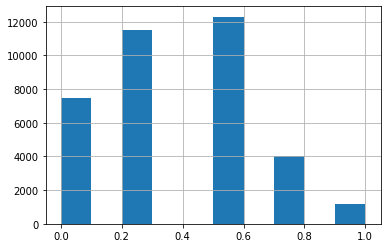

In [36]:
df.score.hist();

In [37]:
df[df.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


观察看见这些完美匹配的pair，发现只是 minor rewordings of the same concept。因此任何pretrained model应该都能很好的处理这种

## Training

In [38]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer
!pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [39]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

指定模型，建立对应的tokenizer

In [40]:
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)

将target,anchor和context用分割符组合起来

In [41]:
sep = tokz.sep_token
sep

'[SEP]'

In [42]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target

转换成Dataset数据类型以便transformer使用

In [43]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

建立Tokenize的函数，以便Dataset.map()

In [44]:
def tok_func(x): return tokz(x["inputs"])

In [45]:
inps = "anchor","target","context"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))

  0%|          | 0/37 [00:00<?, ?ba/s]

我们只关心"input_ids",因此可以将不需要用到的列移除

In [46]:
tok_ds[0]

{'label': 0.5,
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Creating a validation set


因为有论坛网友private test的anchor word与training data不重合，为了拟真这种环境，我们要对应针对anchor word的出现情况，划分我们validation set.  
The private test anchors do not overlap with the training set. So let's do the same thing for our validation set.

In [47]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

我们现在提取25%的anchor word去当作validation set

In [48]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]

获得这些挑选的anchor world对应的样本index

In [49]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

In [50]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

In [51]:
df.iloc[trn_idxs].score.mean(),df.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

## Initial Model

In [52]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [53]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [54]:
trainer = get_trainer(dds)

In [55]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.030484,0.792365
2,No log,0.024315,0.814917
3,0.031600,0.023865,0.817929
4,0.031600,0.024314,0.818387


TrainOutput(global_step=856, training_loss=0.023854037311589606, metrics={'train_runtime': 250.1879, 'train_samples_per_second': 437.383, 'train_steps_per_second': 3.421, 'total_flos': 469191313065600.0, 'train_loss': 0.023854037311589606, 'epoch': 4.0})

## Improving the model

* [baseline模型稳定性和区间的确定] 我们要迭代改进我们的模型。第一步要确定我们现在baseline模型的表现是否是stable的。做了三次训练，发现表现是0.808-0.810之间，发现这是stable的。也即说明如果我们做出任何改进，其表现没有跳出这个区间，则代表改改进是不显著有效果的。
* [为快速迭代改进制造恰当的函数] 因为我们想通过修改数据处理方法和模型来实现改进，因此我们这里制造两个函数能让我们尝试不同的数据处理方法和模型。

In [56]:
def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column('score', 'label')
    tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))
    return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})

In [57]:
def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

### 新方案的尝试1-改变分割符


In [59]:
sep = " [s] "
df['inputs'] = df.context + sep + df.anchor + sep + df.target
dds = get_dds(df)
get_trainer(dds).train()

  0%|          | 0/37 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025409,0.795841
2,No log,0.026482,0.813393
3,0.031500,0.023248,0.821005
4,0.031500,0.024274,0.819712


TrainOutput(global_step=856, training_loss=0.023730961518866993, metrics={'train_runtime': 254.0119, 'train_samples_per_second': 430.799, 'train_steps_per_second': 3.37, 'total_flos': 582440534448480.0, 'train_loss': 0.023730961518866993, 'epoch': 4.0})

### 新方案的尝试2- 全部变成小写


In [60]:
df['inputs'] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

  0%|          | 0/37 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025104,0.796881
2,No log,0.025482,0.814916
3,0.031400,0.022966,0.821749
4,0.031400,0.023986,0.820986


TrainOutput(global_step=856, training_loss=0.02367370039503151, metrics={'train_runtime': 250.2231, 'train_samples_per_second': 437.322, 'train_steps_per_second': 3.421, 'total_flos': 582440534448480.0, 'train_loss': 0.02367370039503151, 'epoch': 4.0})

### 新方案的尝试3- 为context首字母制作special token


In [61]:
df['sectok'] = '[' + df.section + ']'
sectoks = list(df.sectok.unique())
tokz.add_special_tokens({'additional_special_tokens': sectoks})

8

整合三种方案：分割符+小写+special token

In [62]:
df['inputs'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target
dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]

Since we've added more tokens, we need to resize the embedding matrix in the model

In [63]:
model = get_model()
model.resize_token_embeddings(len(tokz))

Embedding(128009, 768)

In [64]:
trainer = get_trainer(dds, model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024854,0.797081
2,No log,0.025419,0.816822
3,0.031700,0.023269,0.821949
4,0.031700,0.023581,0.823755


TrainOutput(global_step=856, training_loss=0.023764223695915437, metrics={'train_runtime': 270.4723, 'train_samples_per_second': 404.581, 'train_steps_per_second': 3.165, 'total_flos': 695689755831360.0, 'train_loss': 0.023764223695915437, 'epoch': 4.0})

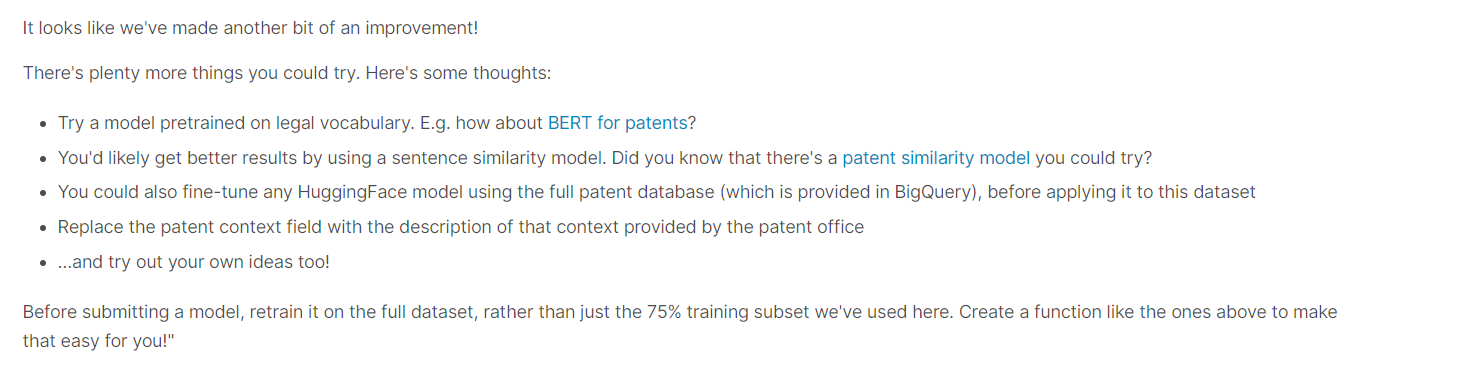

## Cross-validation 
上面的各种新方案尝试是只在一个validation set上的，我们可以用交叉验证来获得更加稳定和全面的结果！

In [65]:
# 注意这里用到了StratifiedGroupKFold，并用anchor作为group. 这能保证anchor在train和test时不会overlap
from sklearn.model_selection import StratifiedGroupKFold
n_folds = 4
cv = StratifiedGroupKFold(n_splits=n_folds)

In [66]:
df = df.sample(frac=1, random_state=42)
scores = (df.score*100).astype(int)
folds = list(cv.split(idxs, scores, df.anchor))
folds

[(array([    0,     1,     2, ..., 36469, 36471, 36472]),
  array([    8,    13,    14, ..., 36453, 36464, 36470])),
 (array([    0,     1,     5, ..., 36470, 36471, 36472]),
  array([    2,     3,     4, ..., 36459, 36461, 36462])),
 (array([    1,     2,     3, ..., 36467, 36470, 36472]),
  array([    0,     7,    11, ..., 36468, 36469, 36471])),
 (array([    0,     2,     3, ..., 36469, 36470, 36471]),
  array([    1,     5,     9, ..., 36465, 36467, 36472]))]

In [67]:
def get_fold(folds, fold_num):
    trn,val = folds[fold_num]
    return DatasetDict({"train":tok_ds.select(trn), "test": tok_ds.select(val)})

In [68]:
dds = get_fold(folds, 0)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})

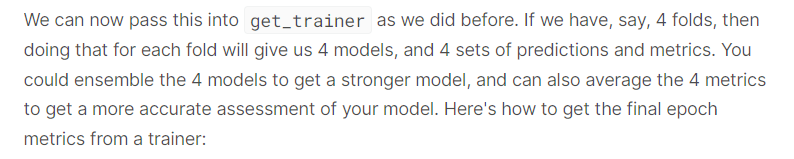

In [69]:
metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
metrics[-1]

0.8237549786571815